In [137]:
import torch
import fastai
import torchvision
import pandas as pd
import numpy as np
import imutils
import cv2
import matplotlib.pyplot  as plt
import matplotlib.image as mpimg

In [138]:
%matplotlib inline

In [139]:
from torchvision.models import vgg

In [140]:
vgg_model = vgg.vgg19(pretrained=True)
# vgg_model = vgg_model.features
for idx in range(len(vgg_model.features)):
    if isinstance(vgg_model.features[idx], torch.nn.MaxPool2d):
        vgg_model.features[idx] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)

In [141]:
conv_indexes = []
for i, layer in enumerate(fastai.children(vgg_model.features)):
    if isinstance(layer, torch.nn.MaxPool2d):
        conv_indexes.append(i-1)
conv_indexes

[]

In [142]:
conv_indexes = []
for i, layer in enumerate(fastai.children(vgg_model.features)):
    if isinstance(layer, torch.nn.Conv2d):
        conv_indexes.append(i)
conv_indexes

[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]

In [143]:
img_path = fastai.Path("/Users/alvaro/Downloads/WhatsApp Image 2018-10-21 at 21.38.56.jpeg")
style_path = fastai.Path("/Users/alvaro/Downloads/3778393_vas_paris-rio.jpg")

In [144]:
image = imutils.resize(mpimg.imread(img_path), 320, 320)[:228, :228]/255
style = imutils.resize(mpimg.imread(style_path), 228, 228)[:228, :228]/255

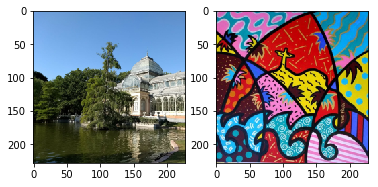

In [145]:
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(style)

In [146]:
import scipy.ndimage
white_image = torch.rand(*image.shape, requires_grad=True)
white_image = scipy.ndimage.filters.median_filter(white_image.detach().numpy(), [8,8,1])
white_image = torch.from_numpy(white_image)
white_image.requires_grad=True

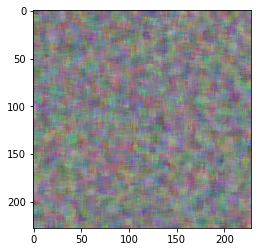

In [147]:
plt.imshow(white_image.detach().cpu().numpy())

In [148]:
# vgg_model(torch.Tensor(i.reshape(1, 3, 224, 224)))

In [149]:
class ForwardHook():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self)
        self.features = None
    def __call__(self, module, input, output):
        self.features = output
    def remove(self):
        self.hook.remove()

hooks = [ForwardHook(vgg_model.features[idx]) for idx in conv_indexes]


In [150]:
# [h.remove() for h in hooks]; None

In [151]:
def loss_content(layer_features_image, layer_features_white_image, layer_idx):
    return torch.nn.functional.mse_loss(layer_features_image[layer_idx], layer_features_white_image[layer_idx])

In [152]:
def loss_style(layer_features_image, layer_features_white_image, conv_indexes):
    losses = []
    for idx in conv_indexes:
        num_filters = layer_features_image[idx].size(0)*layer_features_image[idx].size(1)
        G = torch.mm( layer_features_image[idx].view(num_filters, -1), layer_features_image[idx].view(num_filters, -1).t() )
        A = torch.mm( layer_features_white_image[idx].view(num_filters, -1), layer_features_white_image[idx].view(num_filters, -1).t() )
        loss = torch.nn.functional.mse_loss(G, A) / 100_000_000# (4*(layer_features_image[idx].size(0)**2)*(layer_features_image[idx].size(1)**2)*10000)
        losses.append(loss)
        
    return sum(losses)

In [153]:
optim = torch.optim.Adam([white_image], lr=0.5)

vgg_model.features(torch.Tensor(image.transpose(2, 0, 1)[None])); None
image_features = [h.features.detach().clone() for h in hooks]
# for f in image_features: f.requires_grad = False

vgg_model.features(torch.Tensor(style.transpose(2, 0, 1)[None])); None
style_features = [h.features.detach().clone() for h in hooks]
# for f in style_features: f.requires_grad = False

In [154]:
optim = torch.optim.LBFGS([white_image], lr=0.5, max_iter=10)

In [155]:
def step():
    vgg_model.features(white_image.permute(2, 0, 1).unsqueeze(dim=0)); None
    white_image_features = [h.features for h in hooks]

    optim.zero_grad()
    l1 = loss_content(image_features, white_image_features, 7)/1000
    # l2 = loss_style(style_features, white_image_features, list(range(len(conv_indexes))))
    l2 = loss_style(style_features, white_image_features, [0, 5, 9, 14, 15])
    loss = l1 + l2
    print(loss.data, l1.data, l2.data)
    loss.backward()
    # optim.step()
    return loss

In [156]:
[3, 8, 17, 26, 35]
[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]

[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]

In [157]:
# white_image = torch.load("white_image.pkl").requires_grad

tensor(744.9844) tensor(488.8146) tensor(256.1698)
tensor(743.3806) tensor(487.6755) tensor(255.7051)
tensor(741.7627) tensor(486.3024) tensor(255.4603)
tensor(740.1952) tensor(485.1880) tensor(255.0072)
tensor(738.6974) tensor(484.1104) tensor(254.5870)
tensor(737.2447) tensor(483.0871) tensor(254.1576)
tensor(735.8640) tensor(482.2477) tensor(253.6163)
tensor(734.4604) tensor(481.1180) tensor(253.3425)
tensor(733.1448) tensor(480.4842) tensor(252.6606)
tensor(731.8468) tensor(478.8621) tensor(252.9846)
tensor(730.5801) tensor(478.5596) tensor(252.0204)
tensor(729.3356) tensor(476.8855) tensor(252.4501)
tensor(728.0764) tensor(476.4786) tensor(251.5978)
tensor(726.8198) tensor(475.2148) tensor(251.6050)
tensor(725.5602) tensor(474.4008) tensor(251.1594)
tensor(724.3735) tensor(473.5060) tensor(250.8675)
tensor(723.2302) tensor(472.4915) tensor(250.7388)
tensor(722.1436) tensor(471.7172) tensor(250.4264)
tensor(721.0306) tensor(470.7848) tensor(250.2458)
tensor(719.9291) tensor(470.060

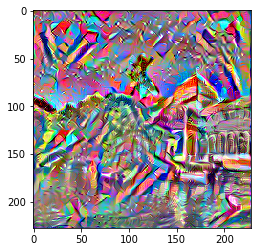

In [166]:
for i in range(2):
    optim.step(lambda: step())
# torch.save(white_image, "white_image.pkl")
plt.imshow(white_image.detach().cpu().numpy())

In [159]:
torch.save(white_image, "white_image.pkl")

In [160]:
# for i in range(30):
#     vgg_model.features(white_image.permute(2, 0, 1).unsqueeze(dim=0)); None
#     white_image_features = [h.features.clone() for h in hooks]
# 
#     optim.zero_grad()
#     l1 = loss_content(image_features, white_image_features, -3)
#     l2 = loss_style(style_features, white_image_features, range(len(conv_indexes)))
#     loss = l1 + l2
#     print(loss.data, l1.data, l2.data)
#     loss.backward()
#     optim.step()
# 
# plt.imshow(white_image.detach().cpu().numpy())

In [161]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)
    (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
 